In [1]:
import sys  
sys.path.insert(0, '/Users/caiorego/Desktop/BDS/RA/Seeding-Bandits/')
import numpy as np

In [2]:
music_before = 14
low_success = 0.50
high_success = 0.90

In [3]:
import src.utils
from src.utils import import_dta, import_tracks_dta, successful_creators_followers,\
gen_active_relations, get_fan_interactions_per_week, calculate_avg_monthly_valence,\
gen_active_relations_prob, get_fan_interactions_per_week_prob, stripplot_prob,\
reaction_probability, follower_list, filter_quantile, sample_creators_music,\
gen_outbound_creators
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mstats
pd.plotting.register_matplotlib_converters()

import src.probability_utils
from src.probability_utils import volume_analysis, valence_analysis
import math
import matplotlib.ticker as plticker
from scipy.interpolate import make_interp_spline, BSpline
import seaborn as sns
from datetime import datetime

In [4]:
path_dir = r"/Users/../Volumes/Raw/"

In [5]:
#we will skip comments for now

#affiliations :follows
#favoritings :likes

tracks = import_tracks_dta(path_dir, "12sample_tracks.dta");
follows_sent = import_dta(path_dir, "12sample_affiliations_sent.dta");
comments_sent = import_dta(path_dir, "12sample_comments_made.dta");
shares_sent = import_dta(path_dir, "12sample_reposts_made.dta");
likes_sent = import_dta(path_dir, "12sample_favoritings_made.dta");
messages_sent = import_dta(path_dir, "12sample_messages_sent.dta");

user_info = import_dta(path_dir, "12sample_user_infos.dta");
user_info_2 = import_dta(path_dir, "12sample_1st_deg_user_infos.dta");
user_info = pd.concat([user_info, user_info_2]);
user_info.drop_duplicates(subset='user_id', keep='first', inplace=True, ignore_index=False);


########
follows_received = import_dta(path_dir, "12sample_affiliations_received.dta");
comments_received = import_dta(path_dir, "12sample_comments_received.dta");
shares_received = import_dta(path_dir, "12sample_reposts_received.dta");
likes_received = import_dta(path_dir, "12sample_favoritings_received.dta");
messages_received = import_dta(path_dir, "12sample_messages_received.dta");

########
follows = import_dta(path_dir, "12sample_affiliations.dta");
comments = import_dta(path_dir, "12sample_comments.dta");
shares = import_dta(path_dir, "12sample_reposts.dta");
likes = import_dta(path_dir, "12sample_favoritings.dta");
messages = import_dta(path_dir, "12sample_messages.dta");

tracks_first_month = sample_creators_music(tracks, music_before)
mask = tracks_first_month.track_available == 1
tracks_first_month = tracks_first_month[mask]

mask = follows_received.contact_id.isin(tracks_first_month.user_id)
follows_received_30 = follows_received[mask]
followers_per_creator_60 = successful_creators_followers(follows_received_30, 60, tracks_first_month)
followers_per_creator_60_static = successful_creators_followers(follows_received_30, 60, tracks_first_month, always_same_batches = True, 
                                                        perc1 = low_success, perc2 = high_success)

%%%%%%%%%% 12sample_tracks.dta %%%%%%%%%%
(56262, 7)
%%%%%%%%%% 12sample_affiliations_sent.dta %%%%%%%%%%
(800913, 3)
%%%%%%%%%% 12sample_comments_made.dta %%%%%%%%%%
(29258, 4)
%%%%%%%%%% 12sample_reposts_made.dta %%%%%%%%%%
(179329, 4)
%%%%%%%%%% 12sample_favoritings_made.dta %%%%%%%%%%
(527701, 4)
%%%%%%%%%% 12sample_messages_sent.dta %%%%%%%%%%
(11091, 3)
%%%%%%%%%% 12sample_user_infos.dta %%%%%%%%%%
(35000, 3)
%%%%%%%%%% 12sample_1st_deg_user_infos.dta %%%%%%%%%%
(670746, 3)
%%%%%%%%%% 12sample_affiliations_received.dta %%%%%%%%%%
(432503, 3)
%%%%%%%%%% 12sample_comments_received.dta %%%%%%%%%%
(21386, 4)
%%%%%%%%%% 12sample_reposts_received.dta %%%%%%%%%%
(83013, 4)
%%%%%%%%%% 12sample_favoritings_received.dta %%%%%%%%%%
(286903, 4)
%%%%%%%%%% 12sample_messages_received.dta %%%%%%%%%%
(17364, 3)
%%%%%%%%%% 12sample_affiliations.dta %%%%%%%%%%
(1233416, 3)
%%%%%%%%%% 12sample_comments.dta %%%%%%%%%%
(50644, 4)
%%%%%%%%%% 12sample_reposts.dta %%%%%%%%%%
(262342, 4)
%%%%%%%%%% 12sam

In [6]:
followers_per_creator_60_static.high_low.value_counts()

low     1284
high     249
Name: high_low, dtype: int64

In [7]:
followers_per_creator_60_static.groupby("high_low").agg(avg_followers = ('followers', 'mean'))

,avg_followers
high_low,
high,244.734940
low,1.584891


In [8]:
followers_per_creator_60_static.groupby("high_low").agg(sum_followers = ('followers', 'sum'))

,sum_followers
high_low,
high,60939.0
low,2035.0


In [9]:
followers_per_creator_60.agg(avg_followers = ('followers', 'mean'))

,followers
avg_followers,33.244839


In [10]:
followers_per_creator_60.agg(avg_followers = ('followers', 'sum'))

,followers
avg_followers,80519.0


In [11]:
actions_sent = gen_outbound_creators(follows_sent, shares_sent, likes_sent, comments_sent, tracks,
                                     messages_sent = messages_sent, filter_creators = True)
mask = actions_sent.user_id.isin(tracks_first_month.user_id.unique())
actions_sent = actions_sent[mask]

In [12]:
actions_sent.user_id.nunique()

1856

In [13]:
actions_sent = actions_sent.merge(followers_per_creator_60_static, left_on = 'user_id', right_on = 'user_id', how = "inner")

In [14]:
user_info.type.value_counts()

           429969
creator    275331
Name: type, dtype: int64

In [15]:
#actions_sent["type"] = actions_sent.type.apply(lambda x: "user" if x != "creator" else x)

In [16]:
followers_per_creator_60_static.groupby("high_low").user_id.nunique()

high_low
high     249
low     1284
Name: user_id, dtype: int64

In [17]:
followers_per_creator_60_static.user_id.nunique()

1533

# All

In [41]:
actions_sent = gen_outbound_creators(follows_sent, shares_sent, likes_sent, comments_sent, tracks,
                                     messages_sent = messages_sent, filter_creators = True)

In [42]:
mask = actions_sent.user_id.isin(tracks_first_month.user_id.unique())
actions_sent = actions_sent[mask]

In [43]:
#two weeks mask
mask = actions_sent.date_sent < (min(actions_sent.date_sent) + pd.Timedelta('14days'))

In [44]:
actions_sent = actions_sent[mask]

In [46]:
table_all = actions_sent.\
groupby(["outbound_activity"], as_index = False).agg(interactions = ('user_id','count'))


table_all["unique_users"] = tracks_first_month.user_id.nunique()

table_all['avg_reaction'] = round(table_all.interactions/table_all.unique_users,2)

In [47]:
table_all

,outbound_activity,interactions,unique_users,avg_reaction
0,comment,631,2422,0.26
1,follow,46589,2422,19.24
2,like,2112,2422,0.87
3,message,277,2422,0.11
4,share,525,2422,0.22


In [52]:
actions_sent = actions_sent.merge(user_info, left_on = 'user_id', right_on = 'user_id')
actions_sent = actions_sent.merge(user_info[['user_id', 'type']], left_on = 'fan_id', right_on = 'user_id', suffixes = ["", "_fan"], how = 'left')
mask = actions_sent.type == 'creator'
actions_sent =  actions_sent[mask]

In [53]:
actions_sent.groupby('outbound_activity', as_index = False).size()

,outbound_activity,size
0,comment,631
1,follow,46589
2,like,2112
3,message,277
4,share,525


In [74]:
46589+631+2112+277+525

50134

In [54]:
actions_sent = actions_sent.merge(followers_per_creator_60_static, left_on = 'user_id', right_on = 'user_id', how = "inner")

In [55]:
actions_sent.groupby('high_low', as_index = False).size()

,high_low,size
0,high,15031
1,low,13847


In [64]:
table_all = actions_sent.\
groupby(["high_low","outbound_activity"], as_index = False).agg(interactions = ('user_id','count'))

tab = actions_sent.groupby('high_low', as_index = False).nunique()

#tab.loc[tab.type == 'user', 'user_id']

table_all.loc[table_all.high_low == 'high','unique_users'] = 249#tab.loc[tab.high_low == 'high', 'user_id'][0]
table_all.loc[table_all.high_low == 'low','unique_users'] = 1284#tab.loc[tab.high_low == 'low', 'user_id'][1]


table_all['avg_reaction'] = round(table_all.interactions/table_all.unique_users,2)

In [65]:
table_all

,high_low,outbound_activity,interactions,unique_users,avg_reaction
0,high,comment,239,249.0,0.96
1,high,follow,13818,249.0,55.49
2,high,like,736,249.0,2.96
3,high,message,116,249.0,0.47
4,high,share,122,249.0,0.49
5,low,comment,91,1284.0,0.07
6,low,follow,13219,1284.0,10.30
7,low,like,387,1284.0,0.30
8,low,message,23,1284.0,0.02
9,low,share,127,1284.0,0.10


In [66]:
followers_per_creator_60_static.shape

(1533, 3)

In [67]:
followers_per_creator_60.shape

(2422, 2)

In [68]:
round(followers_per_creator_60.followers.describe(percentiles=[.1,.2,.3,.4,.5,.6,.7,.8,.9]).to_frame(),1)

,followers
count,2422.0
mean,33.2
std,274.5
min,0.0
10%,0.0
20%,0.0
30%,1.0
40%,3.0
50%,6.0
60%,9.6


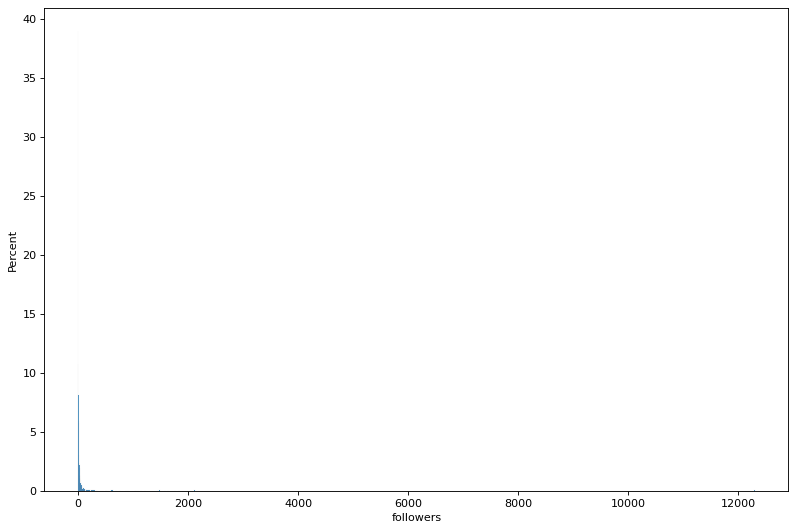

In [69]:
from matplotlib.pyplot import figure

figure(figsize=(12, 8), dpi=80)
sns.histplot(followers_per_creator_60.followers, stat= 'percent');